# Prediction of relevant protein kinase-cancer relations
We aim to learn pairs (x,y), where x is a protein kinase and y is a cancer that 
can be effectively treated by inhibiting x. We use word2vec to embed words found
in abstracts from the PubMed corpus; we use [marea](https://github.com/TheJacksonLaboratory/marea) to preprocess PubMed abstracts by replacing words and phrases with concept IDs, followed by analysis with [embiggen](https://pypi.org/project/embiggen/) for word embedding. This notebook imports the embedded vectors and corresponding labels (words) from embiggen. We then extract vectors that correspond to
both protein kinases and cancers. We use a positive set of (x,y) relations that
we have derived from an analysis of Clinical Trials data with [yatcp](https://github.com/monarch-initiative/yactp), and rank other possible protein-kinase cancer relations.

## How to set up this notebook
This notebook depends on the files ``embedding_SG_dim100_upto{year}.npy``, ``words_SG_upto{year}.txt`` (from embiggen), 
``positive_training_upto_{year}.tsv``, ``negative_training_upto_{year].tsv``, ``positive_validation_after_{year}_pahse_4.tsv``, ``negative_prediction_after_{year}_phase_4.tsv`` from the [KCET](https://github.com/TheJacksonLaboratory/KCET) package. For now, the corresponding files are available in
Google drive. Download that folder to someplace on your drive, and then cd to the KCET/notebooks folder,
and softlist the downloaded folder
```
ln -s /path/to/downloaded/folder/ data
```
This notebook assumes it will find the files there.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sys.path.insert(0, os.path.abspath('../..'))
from kcet import KinasePredictor

## Input files
``embedding_Skipgram_dim100.npy`` is the result of word2vec embedding of pubmed. ``words.txt`` are the corresponding words. A directory of files was downloaded and softlinked to data using ``ln -s <path> data``.

In [2]:
target_year = 2014
num_years_later = 6

In [3]:
data_directory = '../data/embeddings_final'
if not os.path.isdir(data_directory):
    raise FileNotFoundError("Could not find data directory")

embedding_file = os.path.join(data_directory, "embedding_SG_dim100_upto{}.npy".format(target_year))
words_file = os.path.join(data_directory, "words_SG_upto{}.txt".format(target_year))
predictor = KinasePredictor(embeddings=embedding_file, words=words_file)


[INFO] We ingested 234512 labeled word vectors from ../data/embeddings_final/embedding_SG_dim100_upto2014.npy and ../data/embeddings_final/words_SG_upto2014.txt
[INFO] We ingested 522 symbol/NCBI gene id mappings from /Users/ravanv/PycharmProjects/KCET/input/prot_kinase.tsv
[INFO] We ingested 698 meshId/disease mappings from /Users/ravanv/PycharmProjects/KCET/input/neoplasms_labels.tsv



# PubMed Word Embeddings
The following code displays the numbers of word embeddings used as input.

In [4]:
embeddings = predictor.get_embeddings()
embeddings.head(n=10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
cell,-4.980139,-4.249372,-3.656294,-0.215405,-2.485486,-4.880480,0.569936,3.525534,-2.735071,2.929585,...,-1.911128,2.332488,-3.243119,4.112899,6.347937,-2.990223,4.258698,0.921466,-2.977834,-3.045444
patient,-4.358530,-4.682502,-4.189298,0.179848,-3.057365,-6.224209,0.564190,3.037076,-2.552714,4.893758,...,-1.628182,3.522367,-3.043320,2.598499,6.041109,-3.980612,4.440180,2.494890,-2.716677,-3.416752
meshd009369,-3.452896,-2.313226,-4.002501,-0.055844,-2.634709,-5.457378,2.182188,4.629396,-2.170140,4.443802,...,-1.260485,2.104979,-2.468472,3.616910,6.384088,-4.817503,3.437115,0.201313,-1.298782,-2.774735
study,-3.292896,-4.693490,-3.970751,-0.060601,-3.843336,-5.938642,0.274612,3.269480,-3.298679,3.570080,...,-1.680222,3.518521,-3.028906,3.791364,6.290039,-3.225273,4.156088,2.306020,-1.768331,-4.321453
0,-4.786961,-5.267066,-3.948454,0.114782,-3.806814,-6.008698,0.354302,3.986808,-2.879348,5.374468,...,-1.407016,1.880640,-4.056701,2.019548,6.047293,-3.338437,3.639134,2.112144,-1.183349,-4.508092
1,-4.602722,-4.102684,-3.856936,0.102188,-3.808176,-6.234705,0.433967,3.451885,-3.376763,5.740398,...,-1.690624,1.028860,-3.714723,1.761134,6.401217,-3.334288,3.566628,2.315960,-1.486821,-2.868295
use,-5.273597,-3.675604,-3.733992,-0.540895,-3.173968,-7.210793,0.854399,3.138489,-3.250750,3.147972,...,-1.641924,3.309921,-4.030232,4.909722,6.351670,-3.540069,3.175005,2.209906,-2.339851,-3.840097
2,-4.656091,-3.988115,-3.825408,0.095735,-3.932255,-6.569601,0.198396,3.218995,-3.709795,5.808820,...,-1.617544,1.608812,-3.361573,2.266476,6.565827,-3.141440,3.522556,2.079819,-1.926957,-2.978841
treatment,-4.441556,-5.091295,-3.988740,-0.127149,-3.734644,-6.880018,-0.468065,5.039606,-2.906109,5.008976,...,-1.278469,2.690426,-2.885372,4.065932,5.885737,-3.018400,3.511767,1.525648,-1.770803,-3.533768
case,-5.404951,-3.002605,-4.327097,0.242841,-2.333820,-5.229801,0.887384,3.956260,-2.225265,4.664158,...,-1.701103,3.534135,-3.669200,3.440076,7.362900,-3.177783,4.788403,2.113996,-2.838747,-3.045693


In [5]:
print("Total number of embeddings: ", len(embeddings))

Total number of embeddings:  234512


# Positive examples
Note that we need to rename the gene.id to gene_id upstream TODO

In [6]:
positive_examples =  "positive_training_upto_{}.tsv".format(target_year)
positive_df = pd.read_csv(positive_examples,  sep= "\t")[["mesh_id", "gene_id"]]
positive_df.head()

,mesh_id,gene_id
0,meshd002289,ncbigene1956
1,meshd002289,ncbigene2064
2,meshd002289,ncbigene2066
3,meshd007938,ncbigene25
4,meshd007938,ncbigene11183


In [7]:
print("%d positive examples" % len(positive_df))
print("%d embedded words in total" % len(predictor.get_embeddings()))

307 positive examples
234512 embedded words in total


# Difference vectors
We form difference vectors by substracting the word vectors for the protein kinases (in the column ``gene.id``)
from the corresponding vectors for the cancer (in the column ``mesh_id``). The following function in the
KCET package takes the dataframe shown above, finds the corrresponding vectors, substracts them, and
returns a new Pandas dataframe.

In [8]:
diff_vectors_pos_train = predictor.get_disease_kinase_difference_vectors(examples=positive_df)

[INFO] Extracted 246 kinase-cancer difference vectors
[INFO]	Initial data: 307 examples
[INFO]	Could not identify 1 gene ids
[INFO]	Could not identify 1 MeSH ids


In [9]:
diff_vectors_pos_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene1956-meshd002289,0.084409,-1.678300,0.570391,-0.568099,-0.010835,0.572113,-0.322410,0.739851,1.520667,2.166842,...,-0.575982,-1.295671,1.546393,1.501823,0.745674,-0.125327,0.032880,-0.964539,-1.653759,-1.042141
ncbigene2064-meshd002289,-0.369026,-0.722960,0.209369,-1.060191,0.139762,0.383901,-0.069822,0.742758,1.055592,2.474284,...,-0.220842,-1.920477,1.655190,0.945728,0.002300,0.255939,0.853816,-0.957237,-1.405988,-1.630018
ncbigene2066-meshd002289,-0.043715,-0.862368,0.478816,-1.063887,1.431216,1.833705,-0.942973,0.174733,2.030440,1.787186,...,0.007926,-1.074296,0.527892,0.213083,0.165353,0.056865,-0.640007,-0.653880,-1.129007,0.028811
ncbigene25-meshd007938,-0.409652,-0.704031,0.943865,-0.178671,-0.030556,-0.388466,0.692359,-0.573274,-1.647355,1.072487,...,-0.652975,0.923524,1.529238,1.960512,-0.228658,0.389493,0.665099,0.897752,-1.024783,-0.170860
ncbigene11183-meshd007938,2.941060,1.268534,3.065635,0.826578,1.332825,3.187913,-0.649064,0.081814,1.900195,-0.112945,...,1.272254,-1.298478,3.419828,-0.214624,-2.752574,1.857538,-2.017282,-0.098772,1.099827,1.982624


In [10]:
print("%d total difference vectors were extracted." % len(diff_vectors_pos_train))

246 total difference vectors were extracted.


# Negative examples
Here, we process negative examples in the same way. TODO LINK TO EXPLANATION OF HOW WE MAKE POS AND NEG

In [11]:
negative_examples =  "negative_training_upto_{}.tsv".format(target_year)
negative_df = pd.read_csv(negative_examples,  sep= "\t")[["mesh_id", "gene_id"]]
negative_df.head()

,mesh_id,gene_id
0,meshd014516,ncbigene8550
1,meshd018270,ncbigene8899
2,meshd009374,ncbigene4139
3,meshd007953,ncbigene4486
4,meshd009918,ncbigene701


In [12]:
print("%d negative examples" % len(negative_df))

2560 negative examples


In [13]:
diff_vectors_neg_train = predictor.get_disease_kinase_difference_vectors(examples=negative_df)

[INFO] Extracted 2239 kinase-cancer difference vectors
[INFO]	Initial data: 2560 examples
[INFO]	Could not identify 27 gene ids
[INFO]	Could not identify 52 MeSH ids


In [14]:
diff_vectors_neg_train.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene8550-meshd014516,1.025148,1.479311,1.332692,-0.136951,0.951839,1.221514,-0.483217,-0.906381,-0.308752,-1.081818,...,0.835900,-1.764165,1.478426,-0.884900,-1.608714,0.857925,-0.129179,-0.620649,0.671444,-0.229829
ncbigene8899-meshd018270,1.381984,0.196628,2.118607,0.720650,0.644441,1.196168,-0.542780,-2.052259,1.354539,-4.335763,...,0.682153,-0.791583,0.029431,-1.414229,-2.556547,0.266609,-3.784316,-1.549016,1.230323,2.419293
ncbigene4139-meshd009374,-0.152461,-0.671039,0.348963,-0.403591,0.472782,0.519097,-0.566628,-0.444422,-0.425300,0.569307,...,-0.598050,0.120228,0.906438,-0.919764,-0.191176,0.388980,-0.992171,0.545797,1.172171,1.372077
ncbigene701-meshd009918,-0.397456,-1.009560,0.624745,-0.334036,-0.642106,0.344138,-1.153871,-0.972781,-0.579649,-0.246456,...,-0.675011,-0.894121,-0.665099,-0.007459,-0.899164,-1.237750,-0.150421,-0.045882,-0.418718,0.616633
ncbigene140901-meshd012626,0.888945,1.220933,1.153614,0.533691,0.628958,1.226591,-0.481971,-1.262529,0.559009,-1.703029,...,1.807079,-0.697521,0.679577,-1.516546,-2.629609,0.683792,-1.540563,-1.086317,0.519315,1.796047


# PCA visualization
To do PCA, we concatenate the positive and negative examples and label them so that we can visualize them using PCA.

In [15]:
X_train = diff_vectors_pos_train.append(diff_vectors_neg_train)
print("[INFO] We combined positive (n=%d) and negative (n=%d) to the combined dataframe (%d)" % 
      (len(diff_vectors_pos_train), len(diff_vectors_neg_train), len(X_train)))

[INFO] We combined positive (n=246) and negative (n=2239) to the combined dataframe (2485)


In [16]:
X_train.values

array([[ 0.08440852, -1.6783001 ,  0.57039094, ..., -0.9645392 ,
        -1.6537595 , -1.042141  ],
       [-0.36902642, -0.72296023,  0.2093687 , ..., -0.95723665,
        -1.4059885 , -1.6300178 ],
       [-0.043715  , -0.8623681 ,  0.47881627, ..., -0.65387964,
        -1.1290073 ,  0.0288105 ],
       ...,
       [ 0.52025795, -0.88680947,  1.428174  , ..., -1.0103985 ,
        -0.06157589,  0.8787184 ],
       [ 0.04770279, -0.46806622,  0.74237037, ..., -0.8616619 ,
        -0.37578177, -0.46983552],
       [ 0.5652106 , -1.0060163 ,  0.9552822 , ..., -0.9059071 ,
        -0.23471212, -0.21556973]], dtype=float32)

In [17]:
# vector with colors for the data points -- red for positive, blue for negative
cvec = [ "red" if i < len(diff_vectors_pos_train) else "blue" for i in range(len(X_train))]

In [18]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(X_train.values)
df = pd.DataFrame()
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.64428514 0.04041779 0.03140716]


Text(0, 0.5, 'PC 2 (4.04%)')

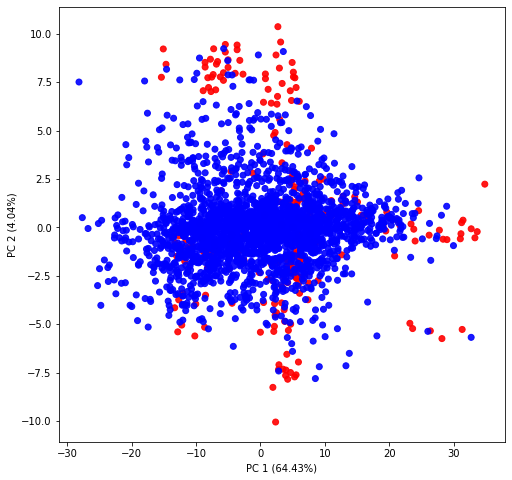

In [19]:
plt.figure(figsize=(8,8))

plt.scatter(pca_result[:,0], pca_result[:,1],c=cvec, alpha=0.9)
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100)) 

# T-Distributed Stochastic Neighbouring Entities (t-SNE) Plot

In [20]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2485 samples in 0.001s...
[t-SNE] Computed neighbors for 2485 samples in 0.068s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2485
[t-SNE] Computed conditional probabilities for sample 2000 / 2485
[t-SNE] Computed conditional probabilities for sample 2485 / 2485
[t-SNE] Mean sigma: 1.001121
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.093483
[t-SNE] KL divergence after 300 iterations: 1.081527
t-SNE done! Time elapsed: 5.07205605506897 seconds


Text(0, 0.5, 'tsne-2d-two')

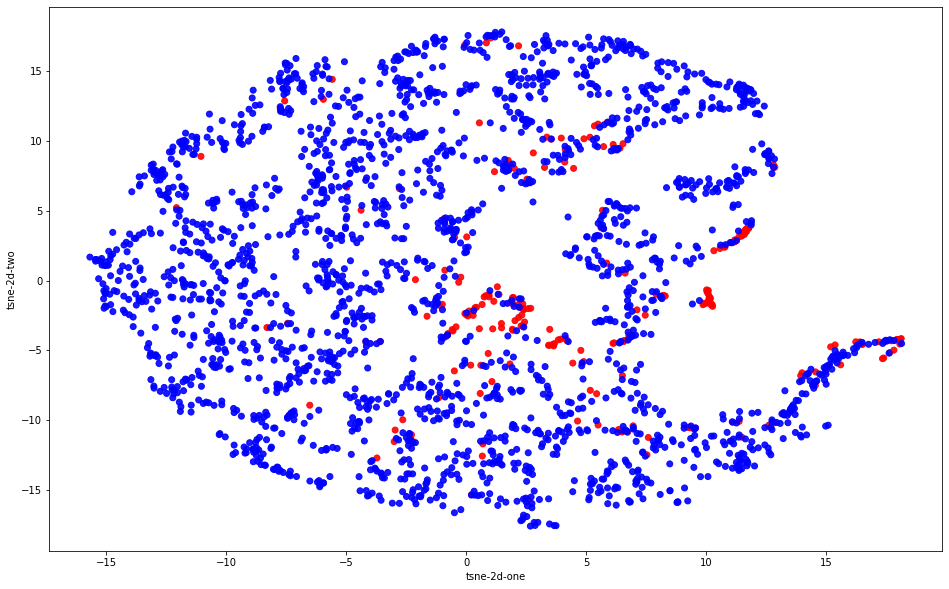

In [21]:
plt.figure(figsize=(16,10))
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cvec,  alpha=0.9)
plt.xlabel('tsne-2d-one')
plt.ylabel('tsne-2d-two') 

# Random forest
First, let's arrange the training data. X_train we have from above. We additionally need to create a data structure for the labels with 1=positive, 0=negative example

In [22]:
print("Training data dimensions:", X_train.shape)

Training data dimensions: (2485, 100)


In [23]:
label_1 = np.ones(diff_vectors_pos_train.shape[0])
label_0 = np.zeros(diff_vectors_neg_train.shape[0])
Y_train = np.concatenate((label_1,label_0))
n_pos_examples = sum([x for x in Y_train])
n_neg_examples = sum([(1-x) for x in Y_train])
print("Number of positive examples: %d, number of negative examples: %d, Y_train.shape: %s" % (n_pos_examples, n_neg_examples, Y_train.shape))

Number of positive examples: 246, number of negative examples: 2239, Y_train.shape: (2485,)


## Positive validation data
Note that for this pilot experiment, we are not checking ROC, but we are just predicting values for all combinations of protein kinases and cancers

In [24]:
positive_validation_data =  "positive_validation_{}_years_after_{}_phase4.tsv".format(num_years_later, target_year)
positive_validation_df = pd.read_csv(positive_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [25]:
positive_validation_df.head()

,mesh_id,gene_id
0,meshd008175,ncbigene2241
1,meshd008258,ncbigene2268
2,meshd002277,ncbigene2322
3,meshd009362,ncbigene6098
4,meshd008258,ncbigene660


In [26]:
diff_vectors_pos_validation = predictor.get_disease_kinase_difference_vectors(positive_validation_df)

[INFO] Extracted 317 kinase-cancer difference vectors
[INFO]	Initial data: 328 examples
[INFO]	Could not identify 0 gene ids
[INFO]	Could not identify 3 MeSH ids


In [27]:
diff_vectors_pos_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene2241-meshd008175,0.704297,-0.051593,1.700550,-0.552007,1.474736,2.711826,-1.363579,-1.869716,2.194090,0.670086,...,0.500799,-0.373550,1.447349,-0.416585,-1.754725,0.967422,-2.365126,-0.974348,-0.133875,1.216230
ncbigene2268-meshd008258,1.438047,0.845331,1.441841,-0.374727,0.862031,0.582141,-0.242756,-0.502840,0.189245,-0.001337,...,0.732252,-1.280737,1.312974,-0.388660,-0.600128,-0.523926,-0.903188,-0.895937,1.343750,1.711692
ncbigene2322-meshd002277,-0.437386,-0.155890,0.019287,-1.686121,0.140731,-0.796359,0.710409,-3.701462,-1.955507,-1.044176,...,-1.105533,2.195482,-1.470559,-1.518600,-2.012582,-0.643241,-0.392206,0.391380,-1.101369,-0.706717
ncbigene6098-meshd009362,0.761939,0.050150,1.538558,-0.612706,1.280216,2.272930,-0.510059,-2.935078,-1.311380,-1.918638,...,-1.302016,-0.114447,0.755845,-0.635742,-2.528207,0.505912,-0.518505,0.012743,1.232084,0.901201
ncbigene660-meshd008258,1.495145,1.493973,1.571168,0.032445,1.832501,1.307350,-0.317456,-0.558848,0.955266,-0.252861,...,0.862654,-0.848804,1.561913,-0.290219,-1.094613,-0.462904,-0.760697,-0.875950,1.509291,2.111517


## Negative validation data

In [28]:
negative_validation_data = "negative_validation_{}_years_after_{}_phase4.tsv".format(num_years_later, target_year)
negative_validation_df = pd.read_csv(negative_validation_data, sep='\t')[["mesh_id", "gene_id"]]


In [29]:
negative_validation_df.head()

,mesh_id,gene_id
0,meshd000239,ncbigene6352
1,meshd002472,ncbigene3717
2,meshd014685,ncbigene5592
3,meshd009507,ncbigene3932
4,meshd005909,ncbigene9113


In [30]:
diff_vectors_neg_validation = predictor.get_disease_kinase_difference_vectors(negative_validation_df)

[INFO] Extracted 2251 kinase-cancer difference vectors
[INFO]	Initial data: 2560 examples
[INFO]	Could not identify 27 gene ids
[INFO]	Could not identify 50 MeSH ids


In [31]:
diff_vectors_neg_validation.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
ncbigene6352-meshd000239,-0.424029,-2.400146,-1.324948,-1.356460,-1.580222,-0.930248,-0.505878,1.387952,-1.384737,1.403548,...,-0.535110,0.816114,-1.602606,0.293705,0.985915,-1.397101,1.371745,0.585797,-0.984385,-0.810281
ncbigene3717-meshd002472,-2.322611,-2.746157,-2.050480,-0.904234,-2.406876,-3.129684,0.929704,0.345887,-2.501638,2.508003,...,-2.047956,1.753024,-1.385733,2.130697,3.235514,-1.675667,2.336464,1.242000,-2.665922,-2.516885
ncbigene3932-meshd009507,-0.779779,-2.640932,-1.400558,-0.823871,-1.710751,-2.880632,-0.506805,1.440317,-2.174313,1.116627,...,-2.130474,1.877908,-1.906658,0.793755,2.482003,-1.316104,1.517657,0.358600,-1.165688,-1.897301
ncbigene9113-meshd005909,0.226516,-1.247125,1.939310,-0.370089,0.855947,1.754082,-1.990317,-2.099465,2.548792,-3.078825,...,0.646048,-1.956813,0.265771,0.474005,-2.163925,1.623090,-1.952194,0.402640,-0.367202,0.062054
ncbigene5062-meshd018222,-1.410695,-1.565338,-1.177180,-0.806741,-1.066426,-1.356783,-1.032038,1.458613,-1.372332,1.615866,...,-1.287704,1.664391,-0.964710,1.082740,2.315630,-1.109476,1.079900,0.085537,-0.554018,-0.721014


# Save binary versions of the data for use in other notebooks
We 'pickle' the three pandas dataframes produced by the code in this notebook.

In [32]:
positive_valid_diff_pickle_path = "positive-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later, target_year)
diff_vectors_pos_validation.to_pickle(positive_valid_diff_pickle_path)

In [33]:
positive_train_diff_pickle_path = "positive-train-vectors-{}.pkl".format(target_year)
diff_vectors_pos_train.to_pickle(positive_train_diff_pickle_path)

In [34]:
negative_train_diff_pickle_path = "negative-train-vectors-{}.pkl".format(target_year)
diff_vectors_neg_train.to_pickle(negative_train_diff_pickle_path)

In [35]:
negative_valid_diff_pickle_path = "negative-valid-vectors-{}-years-after-{}-phase4.pkl".format(num_years_later, target_year)
diff_vectors_neg_validation.to_pickle(negative_valid_diff_pickle_path)